In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.metrics import RootMeanSquaredError
from keras.layers import InputLayer, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [147]:
# Função para salvar todos os dados em um novo arquivo csv
def load_data():
  # Lista para armazenar os DataFrames individuais
  dfs = []

  # Carregar os dados
  for year in range(2007, 2025):
    file_path = f'./data/INMET_MG_PAMPULHA_{year}.csv'
    df = pd.read_csv(file_path, sep=';', encoding='latin1')

    # Adicionar o DataFrame lido à lista
    dfs.append(df)

  # Concatenar todos os DataFrames em um único DataFrame
  data = pd.concat(dfs, ignore_index=True)

  # Renomear colunas
  data.columns = ['Data', 'Hora', 'Precipitação', 'Pressão atmosférica', 'Pressão Atmosférica MAX Hora Ant.',
                  'Pressão Atmosférica MIN Hora Ant.', 'Radiação solar', 'Temperatura ar', 'Temperatura orvalho', 
                  'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 'Temperatura Orvalho MAX Hora Ant.', 
                  'Temperatura Orvalho MIN Hora Ant.', 'Umidade MAX Hora Ant.', 'Umidade MIN Hora Ant.',
                  'Umidade', 'Direção vento', 'Rajada vento', 'Velocidade vento']

  # Remover "UTC" da coluna de tempo
  data['Hora'] = data['Hora'].str.replace(' UTC', '')
  # Converter a hora do formato "HHMM" para "HH:MM"
  data['Hora'] = data['Hora'].apply(lambda x: f"{x[:2]}")
  # Converter data e hora para datetime
  data['datetime'] = pd.to_datetime(data['Data'] + ' ' + data['Hora'], format='%d/%m/%Y %H')
  # Conversão para Unix Timestamp
  data['unix_timestamp'] = data['datetime'].apply(lambda dt: dt.timestamp())

  # Definir 'datetime' como índice e remover as colunas originais de data e hora
  data = data.set_index('datetime')
  data = data.drop(columns=['Data', 'Hora'])

  # Preencher valores ausentes
  data = data.replace(-9999, np.nan)
  data = data.ffill().bfill()

  # Remover linhas com NaN e o índice
  data = data.dropna()

  # Salva os dados relevantes para o treinamento em um novo arquivo csv
  data.to_csv('all_data.csv', sep=';', encoding='latin1')

In [148]:
# Executa a função e salva tudo em um arquivo csv
load_data()

In [152]:
# Carrega os dados
data = pd.read_csv('all_data.csv', sep=';', encoding='latin1')
data = data.set_index('datetime')

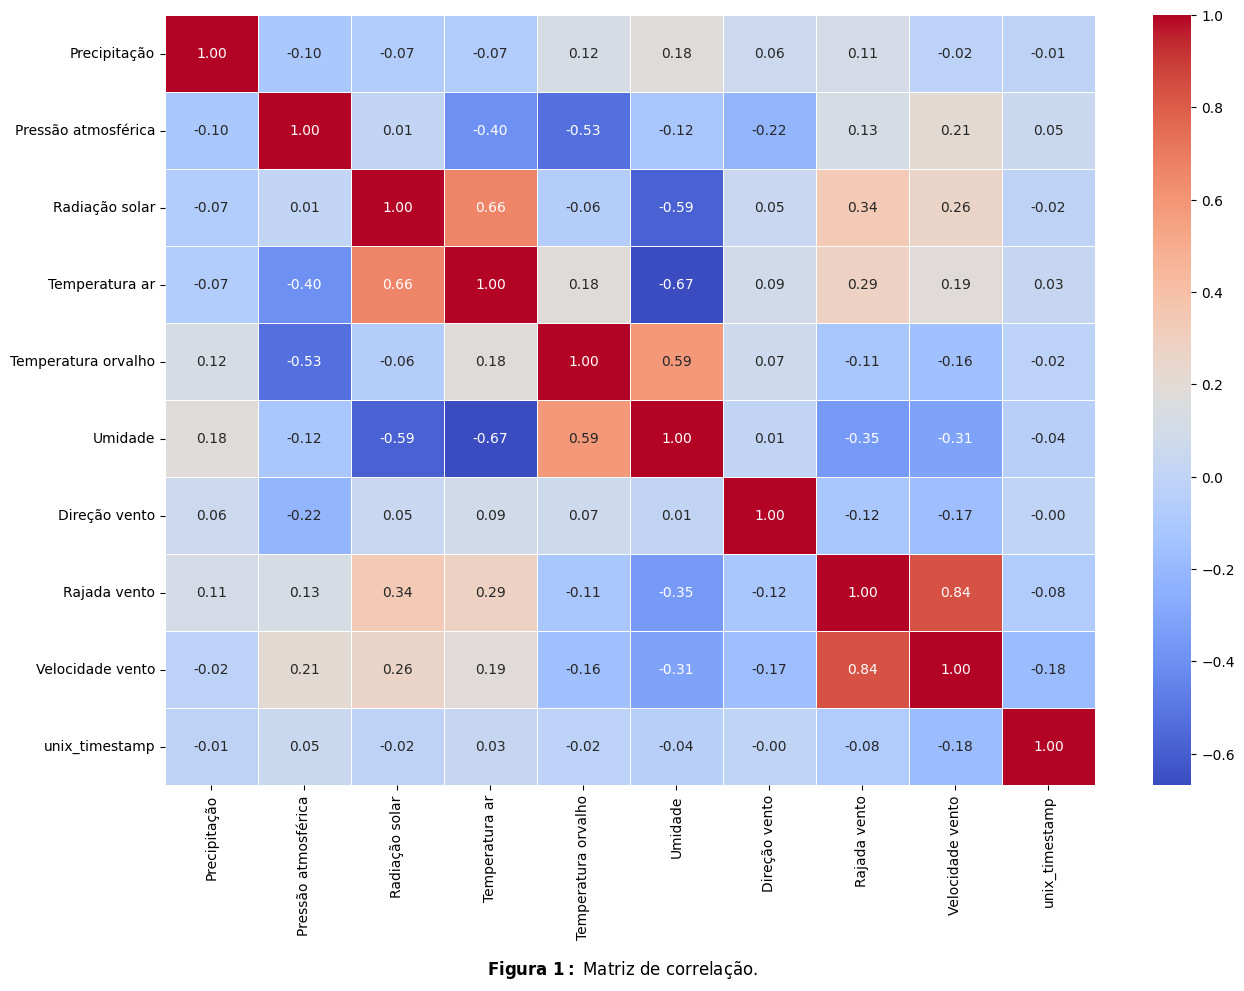

In [4]:
# Plota matriz de correlação
del_data = ['Pressão Atmosférica MAX Hora Ant.', 'Pressão Atmosférica MIN Hora Ant.', 'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 
            'Temperatura Orvalho MAX Hora Ant.', 'Temperatura Orvalho MIN Hora Ant.', 'Umidade MAX Hora Ant.', 'Umidade MIN Hora Ant.',]

correlation_matrix = data.drop(columns=del_data, axis=1).corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.gcf().text(0.43, -0.08, r'$\bf{Figura\ 1:}$ Matriz de correlação.', ha='center', fontsize=12)
plt.show()


In [153]:
# Prepara os dados para o treinamento

# Remove colunas do treinamento
del_data = ['Pressão Atmosférica MAX Hora Ant.', 'Pressão Atmosférica MIN Hora Ant.', 'Temperatura MAX Hora Ant.', 'Temperatura MIN Hora Ant.', 
            'Temperatura Orvalho MAX Hora Ant.', 'Temperatura Orvalho MIN Hora Ant.', 'Umidade MAX Hora Ant.', 'Umidade MIN Hora Ant.',]

X = data.drop(columns=del_data, axis=1).values
y = data['Temperatura ar'].values

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normaliza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Verificar o shape dos dados divididos
print("Shape de X_train:", X_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (122131, 10)
Shape de X_test: (30533, 10)
Shape de y_train: (122131,)
Shape de y_test: (30533,)


In [156]:
# Rede Neural
model = Sequential([
  InputLayer(shape=(X_train.shape[1], 1)),
  Conv1D(filters=32, kernel_size=3, activation='tanh', kernel_regularizer=l2(0.01)),
  MaxPooling1D(pool_size=2),
  Flatten(),
  Dense(16, activation='tanh', kernel_regularizer=l2(0.01)),
  Dense(1)
])

model.compile(optimizer= Adam(learning_rate=1e-3) , loss='mae', metrics=[RootMeanSquaredError()])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, start_from_epoch=100)

history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2, callbacks=[early_stopping], verbose=0)

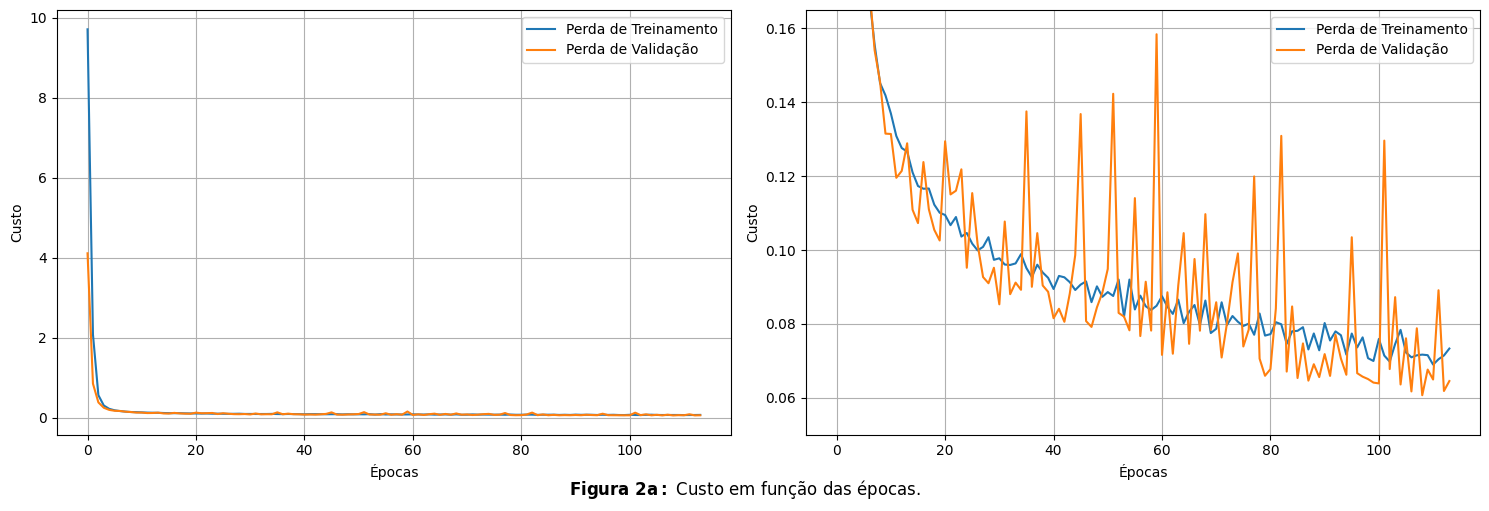

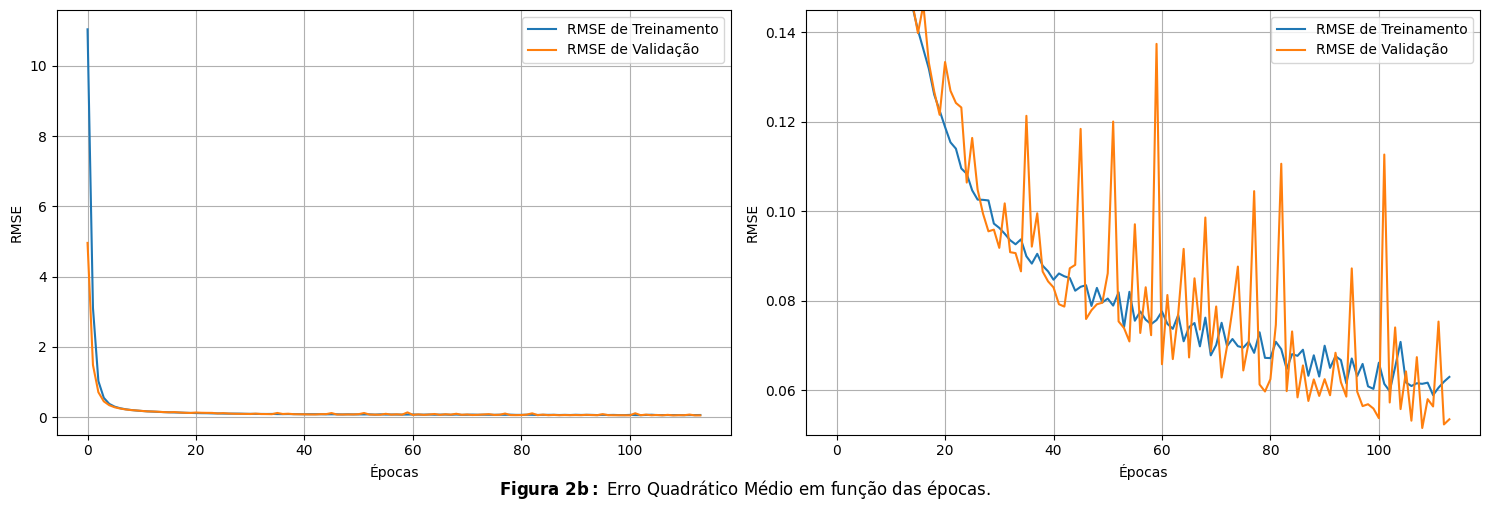

In [164]:
# Plotar a perda
fig_loss, axs_loss = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotar a perda
axs_loss[0].plot(history.history['loss'], label='Perda de Treinamento')
axs_loss[0].plot(history.history['val_loss'], label='Perda de Validação')
axs_loss[0].set_xlabel('Épocas')
axs_loss[0].set_ylabel('Custo')
axs_loss[0].legend()
axs_loss[0].grid(True)

# Plotar a perda - zoom
axs_loss[1].plot(history.history['loss'], label='Perda de Treinamento')
axs_loss[1].plot(history.history['val_loss'], label='Perda de Validação')
axs_loss[1].set_ylim([0.05, 0.165])
axs_loss[1].set_xlabel('Épocas')
axs_loss[1].set_ylabel('Custo')
axs_loss[1].legend()
axs_loss[1].grid(True)

fig_loss.text(0.5, 0, r'$\bf{Figura\ 2a:}$ Custo em função das épocas.', ha='center', fontsize=12)
fig_loss.tight_layout()

# ---------------------------------------------------------------------------------------------
# Plotar a RMSE
fig_metrics, axs_metrics = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plotar RMSE
axs_metrics[0].plot(history.history['root_mean_squared_error'], label='RMSE de Treinamento')
axs_metrics[0].plot(history.history['val_root_mean_squared_error'], label='RMSE de Validação')
axs_metrics[0].set_xlabel('Épocas')
axs_metrics[0].set_ylabel('RMSE')
axs_metrics[0].legend()
axs_metrics[0].grid(True)

# Plotar RMSE - zoom
axs_metrics[1].plot(history.history['root_mean_squared_error'], label='RMSE de Treinamento')
axs_metrics[1].plot(history.history['val_root_mean_squared_error'], label='RMSE de Validação')
axs_metrics[1].set_ylim([0.05, 0.145])
axs_metrics[1].set_xlabel('Épocas')
axs_metrics[1].set_ylabel('RMSE')
axs_metrics[1].legend()
axs_metrics[1].grid(True)

fig_metrics.text(0.5, 0, r'$\bf{Figura\ 2b:}$ Erro Quadrático Médio em função das épocas.', ha='center', fontsize=12)
fig_metrics.tight_layout()


plt.show()

In [174]:
# Avaliar o modelo
mae, rmse = model.evaluate(X_test, y_test, verbose=0)
print(f'Model loss (MAE): {mae} \nRMSE: {rmse}')

y_pred = model.predict(X_test, verbose=0)
r2 = r2_score(y_test, y_pred)
print(f'R square (R²): {r2}')

Model loss (MAE): 0.060138266533613205 
RMSE: 0.04753773659467697
R square (R²): 0.9998605734176605


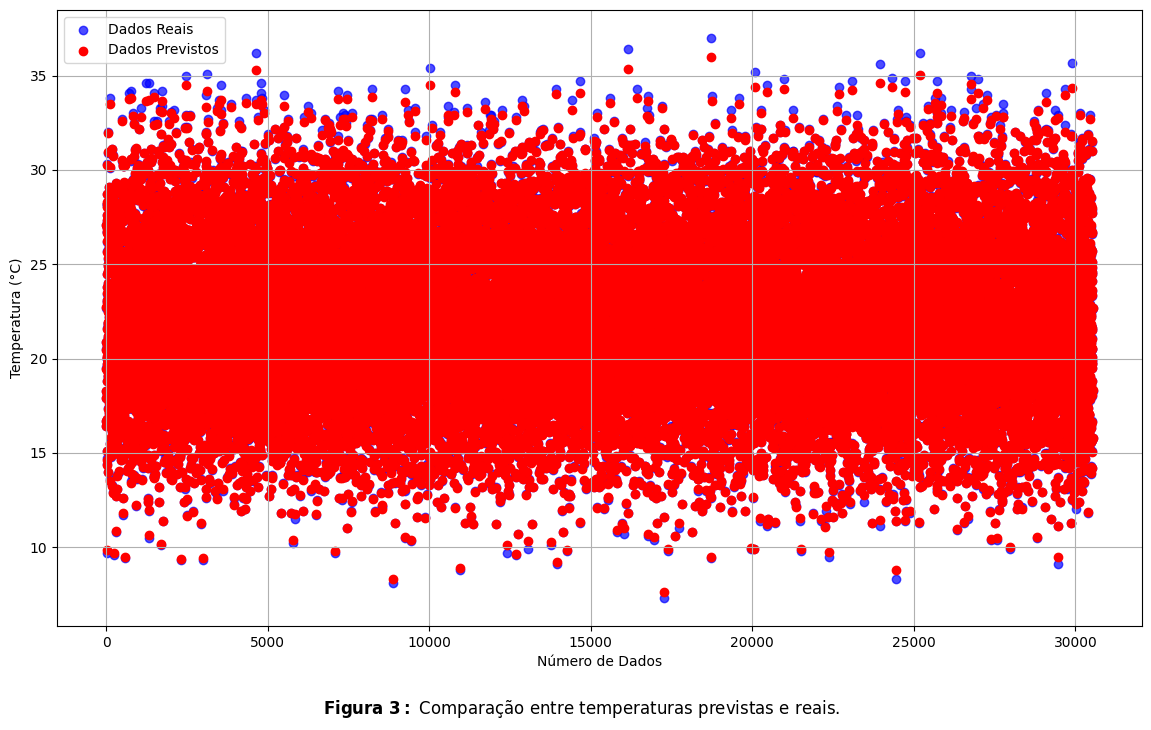

In [169]:
index = np.arange(len(y_pred))

# Plotar os dados reais e previstos no mesmo gráfico
plt.figure(figsize=(14, 8))
plt.scatter(index, y_test, color='blue', label='Dados Reais', alpha=0.7)
plt.scatter(index, y_pred, color='red', label='Dados Previstos')
plt.xlabel('Número de Dados')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.gcf().text(0.5, 0, r'$\bf{Figura\ 3:}$ Comparação entre temperaturas previstas e reais.', ha='center', fontsize=12)

plt.show()


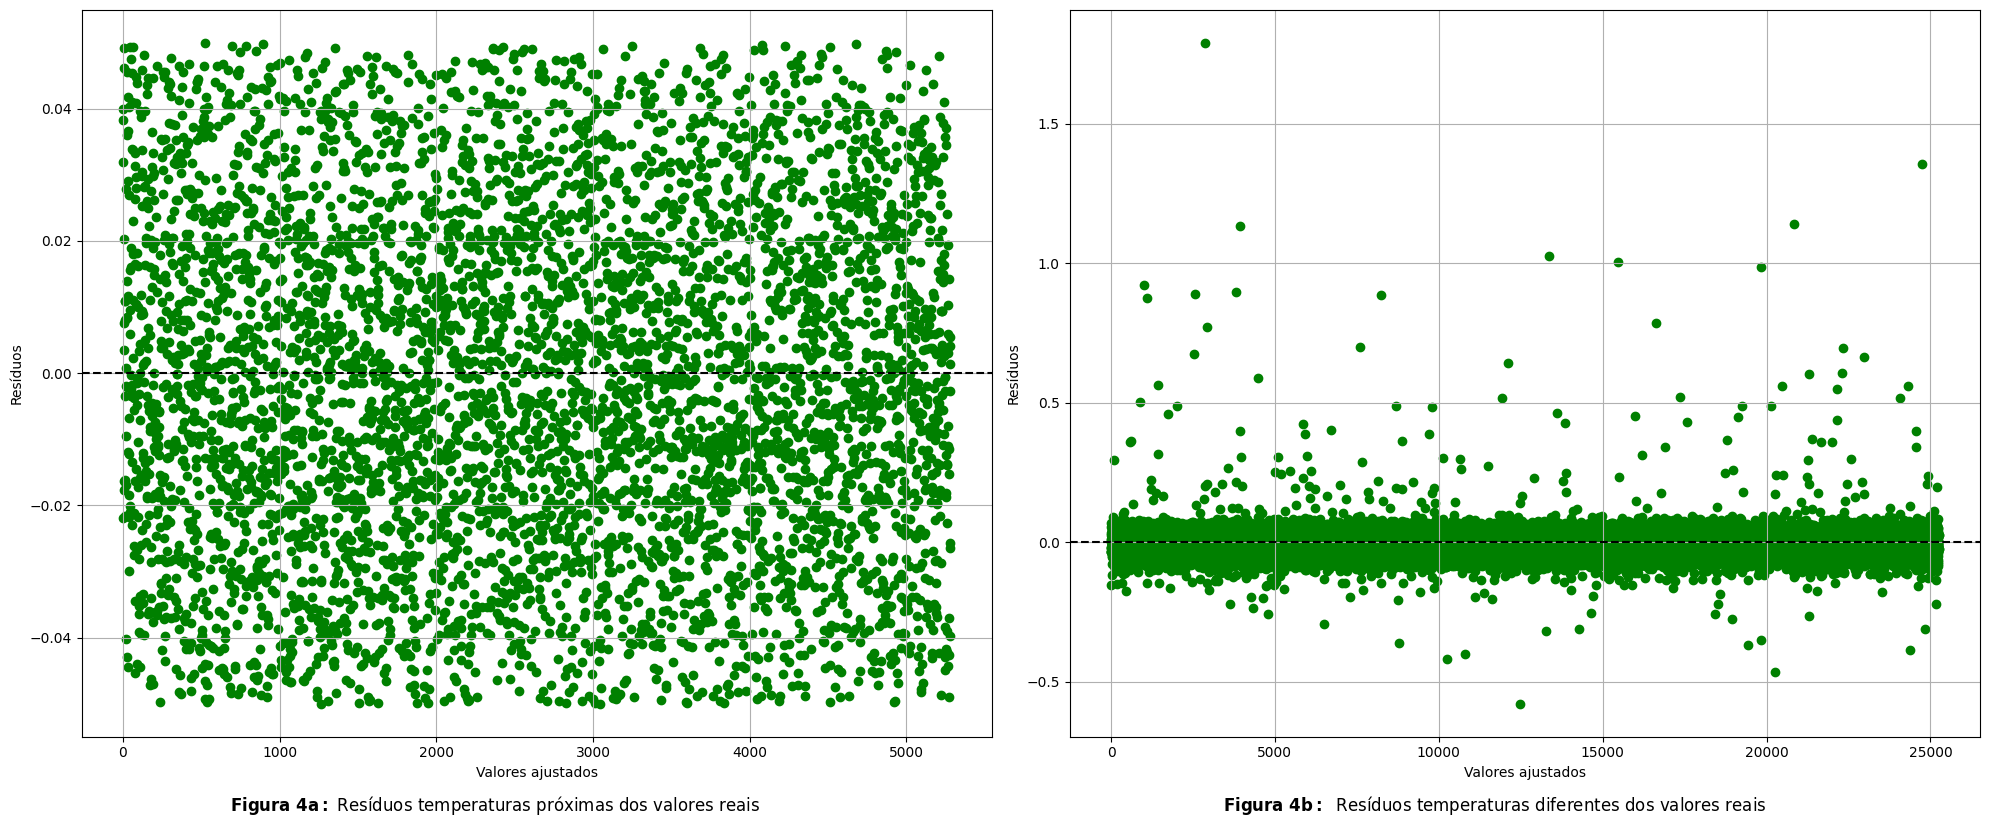

In [173]:
y_pred_wrong = []
y_test_wrong = []

y_pred_right = []
y_test_right = []

for i in range(len(y_pred)):
  if np.round(y_pred[i][0], decimals=1) != y_test[i]:
    y_pred_wrong.append( y_pred[i][0] )
    y_test_wrong.append( y_test[i] )
  else:
    y_pred_right.append( y_pred[i][0] )
    y_test_right.append( y_test[i] )

residue_wrong = np.array(y_test_wrong) - np.array(y_pred_wrong)
index_wrong = np.arange(len(residue_wrong))

residue_right = np.array(y_test_right) - np.array(y_pred_right)
index_right = np.arange(len(residue_right))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

axs[0].scatter(index_right, residue_right, color='green')
axs[0].axhline(y=0, color='black', linestyle='dashed')
axs[0].set_xlabel('Valores ajustados')
axs[0].set_ylabel('Resíduos')
axs[0].grid(True)

axs[1].scatter(index_wrong, residue_wrong, color='green')
axs[1].axhline(y=0, color='black', linestyle='dashed')
axs[1].set_xlabel('Valores ajustados')
axs[1].set_ylabel('Resíduos')
axs[1].grid(True)

fig.text(0.25, -0.02, r'$\bf{Figura\ 4a:}$ Resíduos temperaturas próximas dos valores reais', ha='center', fontsize=12)
fig.text(0.75, -0.02, r'$\bf{Figura\ 4b:}$  Resíduos temperaturas diferentes dos valores reais', ha='center', fontsize=12)

plt.tight_layout()
plt.show()

In [43]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 14, 64)         │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,781 (171.02 KB)

 Trainable params: 14,593 (57.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 29,188 (114.02 KB)

In [176]:
import pickle

model.save('model_history/best_model.keras')

# Salva o histórico
with open("model_history/history_best_model.pkl", "wb") as file:
  pickle.dump(history.history, file)